#### import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql as ps
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.impute import SimpleImputer

#### functions

In [3]:
def read_police_data(police_path = 'data/lapd_police_station_data.csv'):
    df_police = pd.read_csv(police_path)
    df_police['coord'] = list(zip(df_police.Y, df_police.X))
#     min_lat, max_lat = pd.Series([c[0] for c in area_coord]).agg([min, max])
#     min_long, max_long = pd.Series([c[1] for c in area_coord]).agg([min, max])
    
#     check_in_area = df_police['coord'].apply(check_coord_in_rect_area, area_coord = area_coord, minmax_latlong = [min_lat, max_lat, min_long, max_long])
#     df_police_filter = df_police.loc[check_in_area, :]
    
    df_police.columns = pd.Series(df_police.columns).str.replace(' ', '_')
    return df_police

def multi_label_mapping(df_crime_raw):
    #order by crime code
    # split between violent crime and porperty crime
    #based on UCR-COMPSTAT062618.pdf on LAPD crime stats page
    violent_crime = [110,113,121,122,815,820,821,210,220,230,231,235,236,250,251,761,926]
    simple_assault = [435,436,437,622,623,624,625,626,627,647,763,928,930]
    property_crime = [310,320,510,520,433,330,331,410,420,421,350,351,352,353,450,451,452,453,341,\
                      343,345,440,441,442,443,444,445,470,471,472,473,474,475,480,485,487,491]

    # labels where {Violent Crime:0,Simple Assault:1,Property Crime:2,Misc:3}
    label = []
    for i in range(len(df_crime_raw)):
        if df_crime_raw.Crm_Cd.iloc[i] in violent_crime:
            label.append(0)
        elif df_crime_raw.Crm_Cd.iloc[i] in simple_assault:
            label.append(1)
        elif df_crime_raw.Crm_Cd.iloc[i] in property_crime:
            label.append(2)
        else:
            label.append(3)
            
    #create new multilabel crime df
    df_multi_target = df_crime_raw[['Crm_Cd','Crm_Cd_Desc']]

    df_crime_raw['label'] = label
    return df_crime_raw.sort_index()


def read_metro_data(metro_path = 'data/metro_line_data.csv'):
    df_metro = pd.read_csv(metro_path)
    df_metro['coord'] = list(zip(df_metro.Y, df_metro.X))
#     min_lat, max_lat = pd.Series([c[0] for c in area_coord]).agg([min, max])
#     min_long, max_long = pd.Series([c[1] for c in area_coord]).agg([min, max])
    
#     check_in_area = df_metro['coord'].apply(check_coord_in_rect_area, area_coord = area_coord, minmax_latlong = [min_lat, max_lat, min_long, max_long])
#     df_metro_filter = df_metro.loc[check_in_area, :]
    
    df_metro.columns = pd.Series(df_metro.columns).str.replace(' ', '_')
    return df_metro


def read_police_data_filtered(area_coord, police_path = 'data/lapd_police_station_data.csv'):
    df_police = pd.read_csv(police_path)
    df_police['coord'] = list(zip(df_police.Y, df_police.X))
    min_lat, max_lat = pd.Series([c[0] for c in area_coord]).agg([min, max])
    min_long, max_long = pd.Series([c[1] for c in area_coord]).agg([min, max])
    
    check_in_area = df_police['coord'].apply(check_coord_in_rect_area, area_coord = area_coord, minmax_latlong = [min_lat, max_lat, min_long, max_long])
    df_police_filter = df_police.loc[check_in_area, :]
    
    df_police_filter.columns = pd.Series(df_police_filter.columns).str.replace(' ', '_')
    return df_police_filter


def read_metro_data_filtered(area_coord, metro_path = 'data/metro_line_data.csv'):
    df_metro = pd.read_csv(metro_path)
    df_metro['coord'] = list(zip(df_metro.Y, df_metro.X))
    min_lat, max_lat = pd.Series([c[0] for c in area_coord]).agg([min, max])
    min_long, max_long = pd.Series([c[1] for c in area_coord]).agg([min, max])
    
    check_in_area = df_metro['coord'].apply(check_coord_in_rect_area, area_coord = area_coord, minmax_latlong = [min_lat, max_lat, min_long, max_long])
    df_metro_filter = df_metro.loc[check_in_area, :]
    
    df_metro_filter.columns = pd.Series(df_metro_filter.columns).str.replace(' ', '_')
    return df_metro_filter
    
    
def read_crime_data(area_coord, crime_path = 'data/crime_data.csv'):
    df_crime = pd.read_csv(crime_path)
    df_crime['coord'] = list(zip(df_crime.LAT, df_crime.LON))
    min_lat, max_lat = pd.Series([c[0] for c in area_coord]).agg([min, max])
    min_long, max_long = pd.Series([c[1] for c in area_coord]).agg([min, max])
    
    check_in_area = df_crime['coord'].apply(check_coord_in_rect_area, area_coord = area_coord, minmax_latlong = [min_lat, max_lat, min_long, max_long])
    df_crime_filter = df_crime.loc[check_in_area, :]
    
    df_crime_filter.columns = pd.Series(df_crime_filter.columns).str.replace(' ', '_')
    
    return df_crime_filter
    
# function to check if a coordinate is in the rectangular area grid    
def check_coord_in_rect_area(point_coord, area_coord, minmax_latlong):
    min_lat, max_lat, min_long, max_long = minmax_latlong
    if point_coord[0] < min_lat or point_coord[0] > max_lat:
        return False
    elif point_coord[1] < min_long or point_coord[1] > max_long:
        return False
    else:
        return True
    
# function to generate grids coordinates based on the dimension given (row x column)
def gen_grid(area_coord, grid_dimension):
    tot_len_x = area_coord[1][1] - area_coord[0][1]
    tot_len_y = area_coord[0][0] - area_coord[2][0]
    grid_len_x = tot_len_x / grid_dimension[1]
    grid_len_y = tot_len_y / grid_dimension[0]
    
    output_grids = pd.DataFrame(columns = ['grid_num', 'coord_topleft', 'coord_topright', 'coord_botleft', 'coord_botright', 'center_lat', 'center_lon'])
    cnt = 0
    for x in range(grid_dimension[1]):
        for y in range(grid_dimension[0]):
            coord_topleft = (area_coord[0][0] - (y * grid_len_y), area_coord[0][1] + (x * grid_len_x))
            coord_topright = (area_coord[0][0] - (y * grid_len_y), area_coord[0][1] + ((x + 1) * grid_len_x))
            coord_botleft = (area_coord[0][0] - ((y + 1) * grid_len_y), area_coord[0][1] + (x * grid_len_x))
            coord_botright = (area_coord[0][0] - ((y + 1) * grid_len_y), area_coord[0][1] + ((x + 1) * grid_len_x))
            center_lat = (coord_topleft[0] + coord_botleft[0]) / 2
            center_lon = (coord_topleft[1] + coord_topright[1]) / 2
            output_grids.loc[len(output_grids), :] = [cnt, coord_topleft, coord_topright, coord_botleft, coord_botright, center_lat, center_lon]
            cnt += 1
    return output_grids
    
# function to assign grid number to crime data based on area coordinates and grid dimension    
def assign_grid_to_crime_data(df_crime, area_coord, grid_dimension):
    tot_len_x = area_coord[1][1] - area_coord[0][1]
    tot_len_y = area_coord[0][0] - area_coord[2][0]
    grid_len_x = tot_len_x / grid_dimension[1]
    grid_len_y = tot_len_y / grid_dimension[0]
    
    temp_df_crime = df_crime.copy()
    temp_df_crime['projection_x_raw'] = temp_df_crime.LON - area_coord[0][1]
    temp_df_crime['projection_y_raw'] = temp_df_crime.LAT - area_coord[2][0]
    temp_df_crime['projection_x'] = (temp_df_crime.projection_x_raw / grid_len_x).apply(np.floor)
    temp_df_crime['projection_y'] = grid_dimension[0] - 1 - (temp_df_crime.projection_y_raw / grid_len_y).apply(np.floor)
    
    temp_df_crime.loc[temp_df_crime['projection_x'] > (grid_dimension[1] - 1), 'projection_x'] = grid_dimension[1] - 1
    temp_df_crime.loc[temp_df_crime['projection_y'] > (grid_dimension[0] - 1), 'projection_y'] = grid_dimension[0] - 1
    
    temp_df_crime['grid_num'] = temp_df_crime.projection_x * grid_dimension[0] + temp_df_crime.projection_y
    temp_df_crime['grid_num'] = temp_df_crime['grid_num'].astype(int)
    
    return temp_df_crime
        
# function to aggregate crime data by grids    
def gen_df_crime_grid(df_crime_raw_grid, grids_coord):
    
    temp_df = df_crime_raw_grid.loc[:, df_crime_raw_grid.columns != 'coord']
    
    query = '''
    select grid_num
        , count(*) as num_crime_total
        , count(case when label = 0 then 1 end) as num_crime_violent
        , count(case when label = 1 then 1 end) as num_crime_simple_assault
        , count(case when label = 2 then 1 end) as num_crime_property
        , count(case when label = 3 then 1 end) as num_crime_miscellaneous
    from temp_df
    group by 1
    order by 1 ASC
    '''
    df_crime_grid = ps.sqldf(query)
    
    # join with grids coordinates
    df_crime_grid = df_crime_grid.merge(grids_coord, how = 'outer', on = 'grid_num')
    df_crime_grid.sort_values('grid_num', ascending = True, inplace = True)
    return df_crime_grid


def cal_euclidean_dist_feet(coord1, coord2):
    return np.sqrt(((coord1[0] - coord2[0]) * 57.3 * 5280) ** 2 + ((coord1[1] - coord2[1])  * 69.1 * 5280) ** 2)

def cal_manhattan_dist_feet(coord1,coord2):
    return np.absolute(((coord1[0] - coord2[0]) * 57.3 * 5280)) + np.absolute(((coord1[1] - coord2[1])  * 69.1 * 5280))

# function to calculate minimum distance from grid center to target location (metro / police station)
def cal_min_dist_from_center_grid(df_crime_grid, df_target, target_col_name):
    
    temp_df = df_crime_grid.copy()
    for i, row in temp_df.iterrows():
        coord_mid = ((row['coord_topleft'][0] + row['coord_botright'][0]) / 2, \
                     (row['coord_topleft'][1] + row['coord_botright'][1]) / 2)
        min_dist_to_target = min(pd.Series(zip(df_target.Y, df_target.X)).apply(cal_euclidean_dist_feet, \
                                coord2 = coord_mid))
        temp_df.loc[i, target_col_name] = min_dist_to_target
        
    return temp_df

def cal_min_dist_from_center_grid_manhattan(df_crime_grid, df_target, target_col_name):
    
    temp_df = df_crime_grid.copy()
    for i, row in temp_df.iterrows():
        coord_mid = ((row['coord_topleft'][0] + row['coord_botright'][0]) / 2, \
                     (row['coord_topleft'][1] + row['coord_botright'][1]) / 2)
        min_dist_to_target = min(pd.Series(zip(df_target.Y, df_target.X)).apply(cal_manhattan_dist_feet, \
                                coord2 = coord_mid))
        temp_df.loc[i, target_col_name] = min_dist_to_target
        
    return temp_df


def cal_min_dist_from_center_grid_manhattan_v2(grids_coords, df_target, target_col_name):
    
    temp_df = grids_coords.copy()
    for i, row in temp_df.iterrows():
        coord_mid = (row['center_lat'], row['center_lon'])
        min_dist_to_target = min(pd.Series(zip(df_target.Y, df_target.X)).apply(cal_manhattan_dist_feet, \
                                coord2 = coord_mid))
        temp_df.loc[i, target_col_name] = min_dist_to_target
        
    return temp_df



# Define initial parameters: coords and grid dim

In [4]:
# original coordinates: v = vertical, h = horizontal
v_coord = [34.0360, 34.0070]
h_coord = [-118.3100, -118.2670]

# new coordinates
nv_coord = [34.057993, 34.003718]
nh_coord = [-118.326338, -118.246736]


area_coord = [(nv_coord[0],nh_coord[0]),(nv_coord[0],nh_coord[1]),(nv_coord[1],nh_coord[0]),(nv_coord[1],nh_coord[1])]

# default grid dimensions
default_grid_dim = (15, 22)

# buffer factor for threshold to define grid's hot block
buffer_factor = 0.9


# load dataset

In [5]:
# load dataset
df_crime_raw = read_crime_data(area_coord)
df_metro_raw = read_metro_data()
df_police_raw = read_police_data()


# data exploration

In [6]:
# finding % missing values of crime data
df_crime_raw.isna().mean()

DR_NO             0.000000
Date_Rptd         0.000000
DATE_OCC          0.000000
TIME_OCC          0.000000
AREA              0.000000
AREA_NAME         0.000000
Rpt_Dist_No       0.000000
Part_1-2          0.000000
Crm_Cd            0.000000
Crm_Cd_Desc       0.000000
Mocodes           0.130686
Vict_Age          0.000000
Vict_Sex          0.128081
Vict_Descent      0.128081
Premis_Cd         0.000017
Premis_Desc       0.000319
Weapon_Used_Cd    0.582803
Weapon_Desc       0.582803
Status            0.000000
Status_Desc       0.000000
Crm_Cd_1          0.000050
Crm_Cd_2          0.925742
Crm_Cd_3          0.997849
Crm_Cd_4          0.999933
LOCATION          0.000000
Cross_Street      0.763397
LAT               0.000000
LON               0.000000
coord             0.000000
dtype: float64

In [7]:
# finding missing values of metro data
df_metro_raw.isna().mean()

X             0.0
Y             0.0
OBJECTID      0.0
MetroLine     0.0
Station       0.0
StopNumber    0.0
TOOLTIP       0.0
NLA_URL       0.0
coord         0.0
dtype: float64

In [8]:
# finding missing values of police data
df_police_raw.isna().mean()

X           0.0
Y           0.0
FID         0.0
DIVISION    0.0
LOCATION    0.0
PREC        0.0
coord       0.0
dtype: float64

In [9]:
df_crime_raw.describe()

,DR_NO,TIME_OCC,AREA,Rpt_Dist_No,Part_1-2,Crm_Cd,Vict_Age,Premis_Cd,Weapon_Used_Cd,Crm_Cd_1,Crm_Cd_2,Crm_Cd_3,Crm_Cd_4,LAT,LON
count,5.950900e+04,59509.000000,59509.000000,59509.000000,59509.000000,59509.000000,59509.000000,59508.000000,24827.000000,59506.000000,4419.000000,128.000000,4.0,59509.000000,59509.000000
mean,2.073693e+08,1350.256129,6.750760,732.773496,1.407115,505.291250,28.468215,285.014250,360.427478,505.000269,957.604662,978.921875,998.0,34.036082,-118.278327
std,6.530276e+06,658.025394,7.040768,699.767958,0.491301,209.729356,20.459097,218.797973,123.287105,209.487903,109.636628,61.059363,0.0,0.015630,0.022079
min,1.030447e+07,1.000000,1.000000,122.000000,1.000000,110.000000,0.000000,101.000000,101.000000,110.000000,210.000000,626.000000,998.0,34.003800,-118.326300
25%,2.003177e+08,900.000000,1.000000,191.000000,1.000000,330.000000,16.000000,101.000000,308.000000,330.000000,998.000000,998.000000,998.0,34.023500,-118.295900
50%,2.101144e+08,1430.000000,3.000000,338.000000,1.000000,510.000000,29.000000,122.000000,400.000000,510.000000,998.000000,998.000000,998.0,34.040900,-118.274400
75%,2.107172e+08,1900.000000,13.000000,1331.000000,2.000000,626.000000,42.000000,502.000000,400.000000,626.000000,998.000000,998.000000,998.0,34.048700,-118.259000
max,2.299064e+08,2359.000000,20.000000,2099.000000,2.000000,956.000000,99.000000,964.000000,516.000000,956.000000,999.000000,999.000000,998.0,34.057900,-118.246800


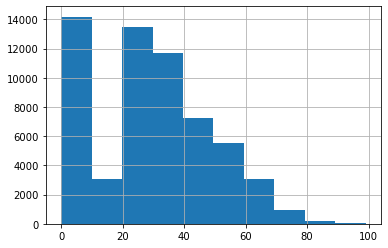

In [9]:
df_crime_raw.Vict_Age.hist()
plt.show()

# preprocessing

In [10]:
# generate coordinates of all grids divided using the area_coord defined
grids_coord = gen_grid(area_coord, default_grid_dim)

#add multi_labels
df_multi_crime_raw = multi_label_mapping(df_crime_raw)

# assign grid number to each crime instance based on area_coord and grid_dim
df_crime_raw_grid = assign_grid_to_crime_data(df_multi_crime_raw, area_coord, default_grid_dim)


C:\Users\orozc\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [11]:
# aggregate crime data by grids
df_crime_grid_proc = gen_df_crime_grid(df_crime_raw_grid, grids_coord)
df_crime_grid_proc

,grid_num,num_crime_total,num_crime_violent,num_crime_simple_assault,num_crime_property,num_crime_miscellaneous,coord_topleft,coord_topright,coord_botleft,coord_botright,center_lat,center_lon
0,0,38,5,3,23,7,"(34.057993, -118.326338)","(34.057993, -118.32271972727273)","(34.05437466666667, -118.326338)","(34.05437466666667, -118.32271972727273)",34.056184,-118.324529
1,1,64,6,6,38,14,"(34.05437466666667, -118.326338)","(34.05437466666667, -118.32271972727273)","(34.05075633333334, -118.326338)","(34.05075633333334, -118.32271972727273)",34.052566,-118.324529
2,2,153,38,25,60,30,"(34.05075633333334, -118.326338)","(34.05075633333334, -118.32271972727273)","(34.047138000000004, -118.326338)","(34.047138000000004, -118.32271972727273)",34.048947,-118.324529
3,3,100,20,17,32,31,"(34.047138000000004, -118.326338)","(34.047138000000004, -118.32271972727273)","(34.04351966666667, -118.326338)","(34.04351966666667, -118.32271972727273)",34.045329,-118.324529
4,4,37,6,7,14,10,"(34.04351966666667, -118.326338)","(34.04351966666667, -118.32271972727273)","(34.03990133333333, -118.326338)","(34.03990133333333, -118.32271972727273)",34.041711,-118.324529
...,...,...,...,...,...,...,...,...,...,...,...,...
325,325,83,15,27,20,21,"(34.02180966666667, -118.25035427272726)","(34.02180966666667, -118.246736)","(34.018191333333334, -118.25035427272726)","(34.018191333333334, -118.246736)",34.020001,-118.248545
326,326,130,25,23,51,31,"(34.018191333333334, -118.25035427272726)","(34.018191333333334, -118.246736)","(34.014573, -118.25035427272726)","(34.014573, -118.246736)",34.016382,-118.248545
327,327,68,5,12,41,10,"(34.014573, -118.25035427272726)","(34.014573, -118.246736)","(34.01095466666666, -118.25035427272726)","(34.01095466666666, -118.246736)",34.012764,-118.248545
328,328,64,17,11,26,10,"(34.01095466666666, -118.25035427272726)","(34.01095466666666, -118.246736)","(34.007336333333335, -118.25035427272726)","(34.007336333333335, -118.246736)",34.009146,-118.248545


In [12]:
# calculate min distance to metro station
df_crime_grid_proc = cal_min_dist_from_center_grid(df_crime_grid_proc, df_metro_raw, target_col_name = 'min_dist_to_metro')

df_crime_grid_proc_manh = cal_min_dist_from_center_grid_manhattan(df_crime_grid_proc, df_metro_raw, target_col_name = 'min_dist_to_metro')

# calculate min distance to police station
df_crime_grid_proc = cal_min_dist_from_center_grid(df_crime_grid_proc, df_police_raw, target_col_name = 'min_dist_to_police')

df_crime_grid_proc_manh = cal_min_dist_from_center_grid_manhattan(df_crime_grid_proc_manh, df_police_raw, target_col_name = 'min_dist_to_police')

In [13]:
df_crime_grid_proc

,grid_num,num_crime_total,num_crime_violent,num_crime_simple_assault,num_crime_property,num_crime_miscellaneous,coord_topleft,coord_topright,coord_botleft,coord_botright,center_lat,center_lon,min_dist_to_metro,min_dist_to_police
0,0,38,5,3,23,7,"(34.057993, -118.326338)","(34.057993, -118.32271972727273)","(34.05437466666667, -118.326338)","(34.05437466666667, -118.32271972727273)",34.056184,-118.324529,5990.877879,7261.677826
1,1,64,6,6,38,14,"(34.05437466666667, -118.326338)","(34.05437466666667, -118.32271972727273)","(34.05075633333334, -118.326338)","(34.05075633333334, -118.32271972727273)",34.052566,-118.324529,6382.443104,6905.063685
2,2,153,38,25,60,30,"(34.05075633333334, -118.326338)","(34.05075633333334, -118.32271972727273)","(34.047138000000004, -118.326338)","(34.047138000000004, -118.32271972727273)",34.048947,-118.324529,6926.564837,6710.037435
3,3,100,20,17,32,31,"(34.047138000000004, -118.326338)","(34.047138000000004, -118.32271972727273)","(34.04351966666667, -118.326338)","(34.04351966666667, -118.32271972727273)",34.045329,-118.324529,7590.505856,6690.744242
4,4,37,6,7,14,10,"(34.04351966666667, -118.326338)","(34.04351966666667, -118.32271972727273)","(34.03990133333333, -118.326338)","(34.03990133333333, -118.32271972727273)",34.041711,-118.324529,6964.317857,6848.669425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,325,83,15,27,20,21,"(34.02180966666667, -118.25035427272726)","(34.02180966666667, -118.246736)","(34.018191333333334, -118.25035427272726)","(34.018191333333334, -118.246736)",34.020001,-118.248545,1995.304494,3603.445930
326,326,130,25,23,51,31,"(34.018191333333334, -118.25035427272726)","(34.018191333333334, -118.246736)","(34.014573, -118.25035427272726)","(34.014573, -118.246736)",34.016382,-118.248545,2224.286476,3019.847077
327,327,68,5,12,41,10,"(34.014573, -118.25035427272726)","(34.014573, -118.246736)","(34.01095466666666, -118.25035427272726)","(34.01095466666666, -118.246736)",34.012764,-118.248545,2882.779714,2766.023937
328,328,64,17,11,26,10,"(34.01095466666666, -118.25035427272726)","(34.01095466666666, -118.246736)","(34.007336333333335, -118.25035427272726)","(34.007336333333335, -118.246736)",34.009146,-118.248545,2684.305974,2929.003025


In [14]:
df_crime_grid_proc_manh

,grid_num,num_crime_total,num_crime_violent,num_crime_simple_assault,num_crime_property,num_crime_miscellaneous,coord_topleft,coord_topright,coord_botleft,coord_botright,center_lat,center_lon,min_dist_to_metro,min_dist_to_police
0,0,38,5,3,23,7,"(34.057993, -118.326338)","(34.057993, -118.32271972727273)","(34.05437466666667, -118.326338)","(34.05437466666667, -118.32271972727273)",34.056184,-118.324529,7420.252645,9531.810666
1,1,64,6,6,38,14,"(34.05437466666667, -118.326338)","(34.05437466666667, -118.32271972727273)","(34.05075633333334, -118.326338)","(34.05075633333334, -118.32271972727273)",34.052566,-118.324529,8514.957685,8437.105626
2,2,153,38,25,60,30,"(34.05075633333334, -118.326338)","(34.05075633333334, -118.32271972727273)","(34.047138000000004, -118.326338)","(34.047138000000004, -118.32271972727273)",34.048947,-118.324529,9609.662725,7342.400586
3,3,100,20,17,32,31,"(34.047138000000004, -118.326338)","(34.047138000000004, -118.32271972727273)","(34.04351966666667, -118.326338)","(34.04351966666667, -118.32271972727273)",34.045329,-118.324529,10704.367765,7106.223848
4,4,37,6,7,14,10,"(34.04351966666667, -118.326338)","(34.04351966666667, -118.32271972727273)","(34.03990133333333, -118.326338)","(34.03990133333333, -118.32271972727273)",34.041711,-118.324529,9652.986809,8200.928888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,325,83,15,27,20,21,"(34.02180966666667, -118.25035427272726)","(34.02180966666667, -118.246736)","(34.018191333333334, -118.25035427272726)","(34.018191333333334, -118.246736)",34.020001,-118.248545,2098.526399,5076.095581
326,326,130,25,23,51,31,"(34.018191333333334, -118.25035427272726)","(34.018191333333334, -118.246736)","(34.014573, -118.25035427272726)","(34.014573, -118.246736)",34.016382,-118.248545,2981.147989,3981.390541
327,327,68,5,12,41,10,"(34.014573, -118.25035427272726)","(34.014573, -118.246736)","(34.01095466666666, -118.25035427272726)","(34.01095466666666, -118.246736)",34.012764,-118.248545,4075.853029,2886.685501
328,328,64,17,11,26,10,"(34.01095466666666, -118.25035427272726)","(34.01095466666666, -118.246736)","(34.007336333333335, -118.25035427272726)","(34.007336333333335, -118.246736)",34.009146,-118.248545,3796.070415,3734.558002


#### find correlation coefficients

In [15]:
# calculate correlation coefficients between # crimes vs min_dist_to_metro and min_dist_to_police
df_crime_grid_proc[['num_crime_total', 'min_dist_to_metro', 'min_dist_to_police']].corr()

,num_crime_total,min_dist_to_metro,min_dist_to_police
num_crime_total,1.000000,-0.337459,-0.294751
min_dist_to_metro,-0.337459,1.000000,0.167709
min_dist_to_police,-0.294751,0.167709,1.000000


In [16]:
# same as above, for manhattan distance 
df_crime_grid_proc_manh[['num_crime_total', 'min_dist_to_metro', 'min_dist_to_police']].corr()

,num_crime_total,min_dist_to_metro,min_dist_to_police
num_crime_total,1.000000,-0.338920,-0.302783
min_dist_to_metro,-0.338920,1.000000,0.183793
min_dist_to_police,-0.302783,0.183793,1.000000


#### scatterplots of features

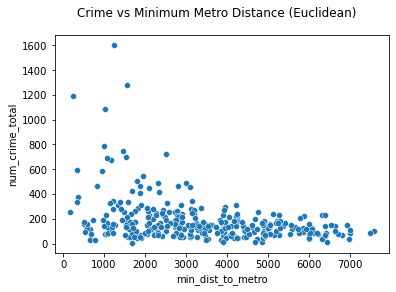

In [18]:
# plot between min_dist_to_metro vs # crimes
sns.scatterplot(data = df_crime_grid_proc, x = 'min_dist_to_metro', y = 'num_crime_total')
plt.suptitle('Crime vs Minimum Metro Distance (Euclidean)')
plt.savefig('crime_metro_euclidean_large.png')

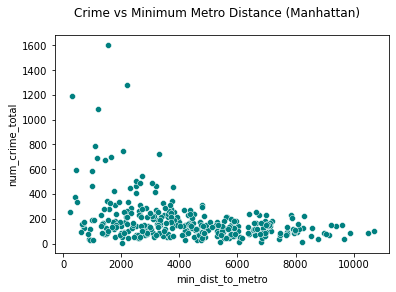

In [18]:
# plot between min_dist_to_metro vs # crimes
sns.scatterplot(data = df_crime_grid_proc_manh, x = 'min_dist_to_metro', y = 'num_crime_total',color='teal')
plt.suptitle('Crime vs Minimum Metro Distance (Manhattan)')
plt.savefig('crime_metro_manhattan_large.png')

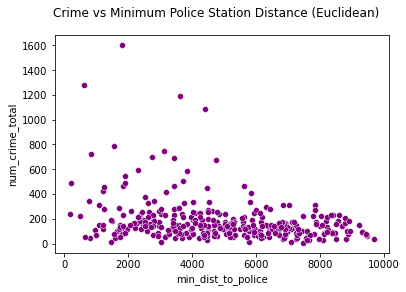

In [19]:
# plot between min_dist_to_police vs # crimes
sns.scatterplot(data = df_crime_grid_proc, x = 'min_dist_to_police', y = 'num_crime_total',color='purple')
plt.suptitle('Crime vs Minimum Police Station Distance (Euclidean)')
plt.savefig('crime_police_euclidean_large.png')

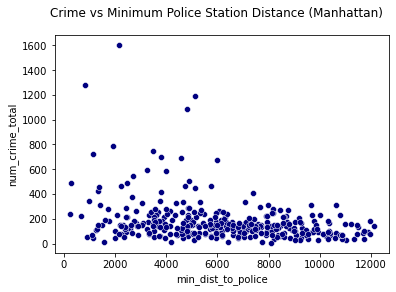

In [20]:
sns.scatterplot(data = df_crime_grid_proc_manh, x = 'min_dist_to_police', y = 'num_crime_total',color='navy')
plt.suptitle('Crime vs Minimum Police Station Distance (Manhattan)')
plt.savefig('crime_police_manhattan_large.png')

# preprocessing2 -> include time features

In [10]:
# generate coordinates of all grids divided using the area_coord defined
grids_coord = gen_grid(area_coord, default_grid_dim)

# calculate distance to the closest metro/police st. on grids_coord
grids_coord = cal_min_dist_from_center_grid_manhattan_v2(grids_coord, df_metro_raw, 'min_dist_metro_manh')
grids_coord = cal_min_dist_from_center_grid_manhattan_v2(grids_coord, df_police_raw, 'min_dist_police_manh')
grids_coord = grids_coord.loc[:, ['grid_num', 'center_lat', 'center_lon', 'min_dist_metro_manh', 'min_dist_police_manh']]

# define list of values for all temporal features
list_weekday = [0, 1]
list_month_sem_open = [0, 1]
list_hour_range = ['hour_00_06', 'hour_06_12', 'hour_12_18', 'hour_18_24']


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:993: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)


In [11]:
# create dataframe of grids + temporal + other features > crime data will be added to these indices later
df_agg = pd.DataFrame(columns = ['grid_num', 'center_lat', 'center_lon', 'min_dist_metro_manh', \
                                 'min_dist_police_manh', 'is_weekday', 'is_month_sem_open', 'hour_range'])

# iterate thru each features to create df of indices
for i, row in grids_coord.iterrows():
    for j in list_weekday:
        for k in list_month_sem_open:
            for m in list_hour_range:
                df_agg.loc[len(df_agg), :] = [*row, j, k, m]



In [12]:
df_agg

,grid_num,center_lat,center_lon,min_dist_metro_manh,min_dist_police_manh,is_weekday,is_month_sem_open,hour_range
0,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_00_06
1,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_06_12
2,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_12_18
3,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_18_24
4,0,34.056184,-118.324529,7420.252645,9531.810666,0,1,hour_00_06
...,...,...,...,...,...,...,...,...
5275,329,34.005527,-118.248545,2701.365375,4829.263042,1,0,hour_18_24
5276,329,34.005527,-118.248545,2701.365375,4829.263042,1,1,hour_00_06
5277,329,34.005527,-118.248545,2701.365375,4829.263042,1,1,hour_06_12
5278,329,34.005527,-118.248545,2701.365375,4829.263042,1,1,hour_12_18


In [14]:
# assign spatiotemporal features to raw crime data

# assign grid number to each crime instance based on area_coord and grid_dim
df_crime_raw_assigned = assign_grid_to_crime_data(df_crime_raw, area_coord, default_grid_dim)

# extract temporal features
df_crime_raw_assigned.loc[:, 'DATE_OCC'] = pd.to_datetime(df_crime_raw_assigned.loc[:, 'DATE_OCC'])

df_crime_raw_assigned.loc[:, 'hour'] = (df_crime_raw_assigned.loc[:, 'TIME_OCC'] / 100).apply(math.floor)
df_crime_raw_assigned.loc[:, 'year'] = pd.DatetimeIndex(df_crime_raw_assigned['DATE_OCC']).year
df_crime_raw_assigned.loc[:, 'month'] = pd.DatetimeIndex(df_crime_raw_assigned['DATE_OCC']).month
df_crime_raw_assigned.loc[:, 'day'] = pd.DatetimeIndex(df_crime_raw_assigned['DATE_OCC']).day
df_crime_raw_assigned.loc[:, 'dayofweek'] = pd.DatetimeIndex(df_crime_raw_assigned['DATE_OCC']).dayofweek

df_crime_raw_assigned.loc[:, 'hour_range'] = np.select(condlist = [df_crime_raw_assigned.loc[:, 'hour'] < 6, df_crime_raw_assigned.loc[:, 'hour'] < 12, \
                                                     df_crime_raw_assigned.loc[:, 'hour'] < 18, df_crime_raw_assigned.loc[:, 'hour'] < 24], \
                                                     choicelist = ['hour_00_06', 'hour_06_12', 'hour_12_18', 'hour_18_24'], \
                                                     default = 'others')
df_crime_raw_assigned.loc[:, 'is_weekday'] = ((pd.DatetimeIndex(df_crime_raw_assigned.loc[:, 'DATE_OCC']).dayofweek) < 5).astype(int)
df_crime_raw_assigned.loc[:, 'is_month_sem_open'] = np.select(condlist = [df_crime_raw_assigned.loc[:, 'month'].isin([5, 6, 7, 12])], \
                                                     choicelist = [0], \
                                                     default = 1)

# filter for year 2020, 2021
df_crime_raw_assigned_filtered = df_crime_raw_assigned[df_crime_raw_assigned.year.isin([2020, 2021])]

df_crime_raw_assigned_filtered

,DR_NO,Date_Rptd,DATE_OCC,TIME_OCC,AREA,AREA_NAME,Rpt_Dist_No,Part_1-2,Crm_Cd,Crm_Cd_Desc,...,projection_y,grid_num,hour,year,month,day,dayofweek,hour_range,is_weekday,is_month_sem_open
0,10304468,01/08/2020 12:00:00 AM,2020-01-08,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,12.0,117,22,2020,1,8,2,hour_18_24,1,1
1,190101086,01/02/2020 12:00:00 AM,2020-01-01,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,3.0,288,3,2020,1,1,2,hour_00_06,1,1
4,200100501,01/02/2020 12:00:00 AM,2020-01-01,30,1,Central,163,1,121,"RAPE, FORCIBLE",...,3.0,303,0,2020,1,1,2,hour_00_06,1,1
5,200100502,01/02/2020 12:00:00 AM,2020-01-02,1315,1,Central,161,1,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),...,2.0,257,13,2020,1,2,3,hour_12_18,1,1
6,200100504,01/04/2020 12:00:00 AM,2020-01-04,40,1,Central,155,2,946,OTHER MISCELLANEOUS CRIME,...,3.0,318,0,2020,1,4,5,hour_00_06,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404376,210311528,06/11/2021 12:00:00 AM,2021-06-11,2130,3,Southwest,356,2,888,TRESPASSING,...,9.0,99,21,2021,6,11,4,hour_18_24,1,0
404379,210111609,06/09/2021 12:00:00 AM,2021-06-07,1500,1,Central,154,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,...,2.0,317,15,2021,6,7,0,hour_12_18,1,0
404398,210120842,11/21/2021 12:00:00 AM,2021-11-18,2100,1,Central,182,1,510,VEHICLE - STOLEN,...,4.0,244,21,2021,11,18,3,hour_18_24,1,1
404405,210216151,10/11/2021 12:00:00 AM,2021-01-01,1200,2,Rampart,295,1,440,THEFT PLAIN - PETTY ($950 & UNDER),...,4.0,184,12,2021,1,1,4,hour_12_18,1,1


In [15]:
# aggregate raw crime data by the selected spatiotemporal features
df_crime_grid = df_crime_raw_assigned_filtered.groupby(['grid_num', 'is_weekday', 'is_month_sem_open', 'hour_range']).size()
df_crime_grid = df_crime_grid.reset_index()
df_crime_grid = df_crime_grid.rename(columns = {0:'num_crime_total'})

temp_df_0 = df_crime_raw_assigned_filtered.loc[df_crime_raw_assigned_filtered['label'] == 0].groupby(['grid_num', 'is_weekday', 'is_month_sem_open', 'hour_range']).size()
temp_df_0 = temp_df_0.reset_index()
temp_df_0 = temp_df_0.rename(columns = {0:'num_crime_total_0'})

temp_df_1 = df_crime_raw_assigned_filtered.loc[df_crime_raw_assigned_filtered['label'] == 1].groupby(['grid_num', 'is_weekday', 'is_month_sem_open', 'hour_range']).size()
temp_df_1 = temp_df_1.reset_index()
temp_df_1 = temp_df_1.rename(columns = {0:'num_crime_total_1'})

temp_df_2 = df_crime_raw_assigned_filtered.loc[df_crime_raw_assigned_filtered['label'] == 2].groupby(['grid_num', 'is_weekday', 'is_month_sem_open', 'hour_range']).size()
temp_df_2 = temp_df_2.reset_index()
temp_df_2 = temp_df_2.rename(columns = {0:'num_crime_total_2'})

temp_df_3 = df_crime_raw_assigned_filtered.loc[df_crime_raw_assigned_filtered['label'] == 3].groupby(['grid_num', 'is_weekday', 'is_month_sem_open', 'hour_range']).size()
temp_df_3 = temp_df_3.reset_index()
temp_df_3 = temp_df_3.rename(columns = {0:'num_crime_total_3'})


KeyError: 'label'

In [28]:
# join df_agg (all indices / features) with df_crime_grid
df_crime_final = df_agg.merge(df_crime_grid, how = 'left', on = ['grid_num', 'is_weekday', 'is_month_sem_open', 'hour_range'])
df_crime_final = df_crime_final.merge(temp_df_0, how = 'left', on = ['grid_num', 'is_weekday', 'is_month_sem_open', 'hour_range'])
df_crime_final = df_crime_final.merge(temp_df_1, how = 'left', on = ['grid_num', 'is_weekday', 'is_month_sem_open', 'hour_range'])
df_crime_final = df_crime_final.merge(temp_df_2, how = 'left', on = ['grid_num', 'is_weekday', 'is_month_sem_open', 'hour_range'])
df_crime_final = df_crime_final.merge(temp_df_3, how = 'left', on = ['grid_num', 'is_weekday', 'is_month_sem_open', 'hour_range'])
df_crime_final = df_crime_final.fillna(0)

df_crime_final



,grid_num,center_lat,center_lon,min_dist_metro_manh,min_dist_police_manh,is_weekday,is_month_sem_open,hour_range,num_crime_total,num_crime_total_0,num_crime_total_1,num_crime_total_2,num_crime_total_3
0,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_00_06,0.0,0.0,0.0,0.0,0.0
1,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_06_12,2.0,0.0,1.0,1.0,0.0
2,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_12_18,2.0,0.0,0.0,2.0,0.0
3,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_18_24,1.0,0.0,0.0,1.0,0.0
4,0,34.056184,-118.324529,7420.252645,9531.810666,0,1,hour_00_06,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,329,34.005527,-118.248545,2701.365375,4829.263042,1,0,hour_18_24,7.0,1.0,1.0,5.0,0.0
5276,329,34.005527,-118.248545,2701.365375,4829.263042,1,1,hour_00_06,3.0,1.0,0.0,2.0,0.0
5277,329,34.005527,-118.248545,2701.365375,4829.263042,1,1,hour_06_12,5.0,1.0,1.0,1.0,2.0
5278,329,34.005527,-118.248545,2701.365375,4829.263042,1,1,hour_12_18,15.0,3.0,5.0,3.0,4.0


In [29]:
# create new target column avg_crime_daily ~ num_crime_total + is_weekday + is_month_sem_open + hour_range
df_crime_final['avg_crime_daily'] = (
                # divide by 2 to make it per year
                df_crime_final['num_crime_total'] / 2 *
                # make it per month
                np.where(df_crime_final['is_month_sem_open'] == 0, 1/4, 1/8) *
                # make it per day (mult by 4 as it's a 6-hour range)
                np.where(df_crime_final['is_weekday'] == 0, 1/(30*2/7), 1/(30*5/7)) * 4)

df_crime_final['avg_0_crime_daily'] = (
                # divide by 2 to make it per year
                df_crime_final['num_crime_total_0'] / 2 *
                # make it per month
                np.where(df_crime_final['is_month_sem_open'] == 0, 1/4, 1/8) *
                # make it per day (mult by 4 as it's a 6-hour range)
                np.where(df_crime_final['is_weekday'] == 0, 1/(30*2/7), 1/(30*5/7)) * 4)

df_crime_final['avg_1_crime_daily'] = (
                # divide by 2 to make it per year
                df_crime_final['num_crime_total_1'] / 2 *
                # make it per month
                np.where(df_crime_final['is_month_sem_open'] == 0, 1/4, 1/8) *
                # make it per day (mult by 4 as it's a 6-hour range)
                np.where(df_crime_final['is_weekday'] == 0, 1/(30*2/7), 1/(30*5/7)) * 4)

df_crime_final['avg_2_crime_daily'] = (
                # divide by 2 to make it per year
                df_crime_final['num_crime_total_2'] / 2 *
                # make it per month
                np.where(df_crime_final['is_month_sem_open'] == 0, 1/4, 1/8) *
                # make it per day (mult by 4 as it's a 6-hour range)
                np.where(df_crime_final['is_weekday'] == 0, 1/(30*2/7), 1/(30*5/7)) * 4)

df_crime_final['avg_3_crime_daily'] = (
                # divide by 2 to make it per year
                df_crime_final['num_crime_total_3'] / 2 *
                # make it per month
                np.where(df_crime_final['is_month_sem_open'] == 0, 1/4, 1/8) *
                # make it per day (mult by 4 as it's a 6-hour range)
                np.where(df_crime_final['is_weekday'] == 0, 1/(30*2/7), 1/(30*5/7)) * 4)


df_crime_final[0] = df_crime_final.num_crime_total_0/df_crime_final.avg_crime_daily
df_crime_final[1] = df_crime_final.num_crime_total_1/df_crime_final.avg_crime_daily
df_crime_final[2] = df_crime_final.num_crime_total_2/df_crime_final.avg_crime_daily
df_crime_final[3] = df_crime_final.num_crime_total_3/df_crime_final.avg_crime_daily
df_crime_final
    

,grid_num,center_lat,center_lon,min_dist_metro_manh,min_dist_police_manh,is_weekday,is_month_sem_open,hour_range,num_crime_total,num_crime_total_0,...,num_crime_total_3,avg_crime_daily,avg_0_crime_daily,avg_1_crime_daily,avg_2_crime_daily,avg_3_crime_daily,0,1,2,3
0,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_00_06,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
1,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_06_12,2.0,0.0,...,0.0,0.116667,0.000000,0.058333,0.058333,0.000000,0.000000,8.571429,8.571429,0.000000
2,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_12_18,2.0,0.0,...,0.0,0.116667,0.000000,0.000000,0.116667,0.000000,0.000000,0.000000,17.142857,0.000000
3,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_18_24,1.0,0.0,...,0.0,0.058333,0.000000,0.000000,0.058333,0.000000,0.000000,0.000000,17.142857,0.000000
4,0,34.056184,-118.324529,7420.252645,9531.810666,0,1,hour_00_06,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,329,34.005527,-118.248545,2701.365375,4829.263042,1,0,hour_18_24,7.0,1.0,...,0.0,0.163333,0.023333,0.023333,0.116667,0.000000,6.122449,6.122449,30.612245,0.000000
5276,329,34.005527,-118.248545,2701.365375,4829.263042,1,1,hour_00_06,3.0,1.0,...,0.0,0.035000,0.011667,0.000000,0.023333,0.000000,28.571429,0.000000,57.142857,0.000000
5277,329,34.005527,-118.248545,2701.365375,4829.263042,1,1,hour_06_12,5.0,1.0,...,2.0,0.058333,0.011667,0.011667,0.011667,0.023333,17.142857,17.142857,17.142857,34.285714
5278,329,34.005527,-118.248545,2701.365375,4829.263042,1,1,hour_12_18,15.0,3.0,...,4.0,0.175000,0.035000,0.058333,0.035000,0.046667,17.142857,28.571429,17.142857,22.857143


In [30]:
# discretize 'avg_crime_daily' as binary output
thres = df_crime_final['avg_crime_daily'].mean() * buffer_factor  ## buffer factor
df_crime_final['is_hot_block'] = np.where(df_crime_final['avg_crime_daily'] > thres, 1, 0)
df_crime_final

,grid_num,center_lat,center_lon,min_dist_metro_manh,min_dist_police_manh,is_weekday,is_month_sem_open,hour_range,num_crime_total,num_crime_total_0,...,avg_crime_daily,avg_0_crime_daily,avg_1_crime_daily,avg_2_crime_daily,avg_3_crime_daily,0,1,2,3,is_hot_block
0,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_00_06,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0
1,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_06_12,2.0,0.0,...,0.116667,0.000000,0.058333,0.058333,0.000000,0.000000,8.571429,8.571429,0.000000,0
2,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_12_18,2.0,0.0,...,0.116667,0.000000,0.000000,0.116667,0.000000,0.000000,0.000000,17.142857,0.000000,0
3,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_18_24,1.0,0.0,...,0.058333,0.000000,0.000000,0.058333,0.000000,0.000000,0.000000,17.142857,0.000000,0
4,0,34.056184,-118.324529,7420.252645,9531.810666,0,1,hour_00_06,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,329,34.005527,-118.248545,2701.365375,4829.263042,1,0,hour_18_24,7.0,1.0,...,0.163333,0.023333,0.023333,0.116667,0.000000,6.122449,6.122449,30.612245,0.000000,0
5276,329,34.005527,-118.248545,2701.365375,4829.263042,1,1,hour_00_06,3.0,1.0,...,0.035000,0.011667,0.000000,0.023333,0.000000,28.571429,0.000000,57.142857,0.000000,0
5277,329,34.005527,-118.248545,2701.365375,4829.263042,1,1,hour_06_12,5.0,1.0,...,0.058333,0.011667,0.011667,0.011667,0.023333,17.142857,17.142857,17.142857,34.285714,0
5278,329,34.005527,-118.248545,2701.365375,4829.263042,1,1,hour_12_18,15.0,3.0,...,0.175000,0.035000,0.058333,0.035000,0.046667,17.142857,28.571429,17.142857,22.857143,0


In [31]:
# set multi-label majorities
temp_df = df_crime_final[[0,1,2,3]].idxmax(axis=1)
l = ['num_crime_total_0','num_crime_total_1','num_crime_total_2','num_crime_total_3','avg_0_crime_daily','avg_1_crime_daily',\
    'avg_2_crime_daily','avg_3_crime_daily',0,1,2,3]
df_crime_final = pd.merge(df_crime_final,temp_df.rename('label_majority'),right_index=True,left_index=True)
df_crime_final = df_crime_final.drop(l,axis=1)
df_crime_final

,grid_num,center_lat,center_lon,min_dist_metro_manh,min_dist_police_manh,is_weekday,is_month_sem_open,hour_range,num_crime_total,avg_crime_daily,is_hot_block,label_majority
0,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_00_06,0.0,0.000000,0,NaN
1,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_06_12,2.0,0.116667,0,1.0
2,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_12_18,2.0,0.116667,0,2.0
3,0,34.056184,-118.324529,7420.252645,9531.810666,0,0,hour_18_24,1.0,0.058333,0,2.0
4,0,34.056184,-118.324529,7420.252645,9531.810666,0,1,hour_00_06,0.0,0.000000,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5275,329,34.005527,-118.248545,2701.365375,4829.263042,1,0,hour_18_24,7.0,0.163333,0,2.0
5276,329,34.005527,-118.248545,2701.365375,4829.263042,1,1,hour_00_06,3.0,0.035000,0,2.0
5277,329,34.005527,-118.248545,2701.365375,4829.263042,1,1,hour_06_12,5.0,0.058333,0,3.0
5278,329,34.005527,-118.248545,2701.365375,4829.263042,1,1,hour_12_18,15.0,0.175000,0,1.0


In [32]:
# final preprocess

# dummy encoding hour_range column
df_crime_final_enc = pd.get_dummies(df_crime_final, columns = ['hour_range'], drop_first = True)

# split training / testing data
df_X = df_crime_final_enc.loc[:, [col for col in df_crime_final_enc.columns if col not in ['is_hot_block', 'grid_num', 'num_crime_total', 'avg_crime_daily','label_majority']]]
df_y = df_crime_final_enc.loc[:, 'is_hot_block']
df_y_multi = df_crime_final_enc.loc[:,'label_majority']
df_train_X, df_test_X, df_train_y, df_test_y, df_multi_train_y, df_multi_test_y = train_test_split(df_X, df_y, df_y_multi, test_size = 0.25, random_state = 0)



# standardize features
scaler = StandardScaler()
df_train_X = pd.DataFrame(scaler.fit_transform(df_train_X), columns = df_train_X.columns)
df_test_X = pd.DataFrame(scaler.transform(df_test_X), columns = df_test_X.columns)



In [40]:
# functions for training classifier


def generate_test_scores_binary_buffer_factor(cls_list, df_test_X, df_test_y, buffer_factor,
                               cls_name_list = ['KNN', 'NB', 'LogReg', 'LogReg - L1',
                                               'LogReg - L2', 'SVM', 'SVM - Kernel', 'DT', 'Bagging', 'RF']):
    df_result = pd.DataFrame(columns = ['Buffer factor', 'Classifier', 'Accuracy', 
                                        'Precision Score', 'Recall Score', 'F1 Score', 'ROC AUC Score'])
    for name, cls in enumerate(cls_list):
        acc = cls.score(df_test_X, df_test_y)
        precision = precision_score(df_test_y, cls.predict(df_test_X))
        recall = recall_score(df_test_y, cls.predict(df_test_X))
        f1 = f1_score(df_test_y, cls.predict(df_test_X))
        roc_auc = roc_auc_score(df_test_y, cls.predict_proba(df_test_X)[:, 1])
        df_result.loc[len(df_result), :] = [buffer_factor, cls_name_list[name], acc, precision, recall, f1, roc_auc]
    return df_result

def generate_test_scores_binary_grid_dim(cls_list, df_test_X, df_test_y, grid_dim,
                               cls_name_list = ['KNN', 'NB', 'LogReg', 'LogReg - L1',
                                               'LogReg - L2', 'SVM', 'SVM - Kernel', 'DT', 'Bagging', 'RF']):
    df_result = pd.DataFrame(columns = ['Grid Dimension', 'Classifier', 'Accuracy', 
                                        'Precision Score', 'Recall Score', 'F1 Score', 'ROC AUC Score'])
    for name, cls in enumerate(cls_list):
        acc = cls.score(df_test_X, df_test_y)
        precision = precision_score(df_test_y, cls.predict(df_test_X))
        recall = recall_score(df_test_y, cls.predict(df_test_X))
        f1 = f1_score(df_test_y, cls.predict(df_test_X))
        roc_auc = roc_auc_score(df_test_y, cls.predict_proba(df_test_X)[:, 1])
        df_result.loc[len(df_result), :] = [grid_dim, cls_name_list[name], acc, precision, recall, f1, roc_auc]
    return df_result
        

def report_test_scores_binary(cls, df_test_X, df_test_y):
    print('------- Test Set Evaluation Metrics --------')
    print('Accuracy:', '{:.4%}'.format(cls.score(df_test_X, df_test_y)))
    print('Precision score:', '{:.4%}'.format(precision_score(df_test_y, cls.predict(df_test_X))))
    print('Recall score:', '{:.4%}'.format(recall_score(df_test_y, cls.predict(df_test_X))))
    print('F1 score:', '{:.4%}'.format(f1_score(df_test_y, cls.predict(df_test_X))))
    print('ROC AUC score:', '{:.4%}'.format(roc_auc_score(df_test_y, cls.predict_proba(df_test_X)[:, 1])))

def report_test_scores_multi(cls, x, y):
    print('------- Test Set Evaluation Metrics --------')
    print('Accuracy:', '{:.4%}'.format(cls.score(x,y)))
    print('Precision score:'+str(precision_score(y, cls.predict(x),average=None)))
    print('Recall score:'+str(recall_score(y, cls.predict(x),average=None)))
    print('F1 score:'+str(f1_score(y, cls.predict(x),average=None)))    


def train_cls_knn(df_train_X, df_train_y, hp_params, cls_objective = 'binary'):
    if cls_objective == 'binary':
        # cross validate
        cls = KNeighborsClassifier()
        cls_cv = GridSearchCV(cls, hp_params, cv = 5, scoring = 'accuracy')
        cls_cv.fit(df_train_X, df_train_y)
        # get the best model
        cls_best = cls_cv.best_estimator_
        print('Best parameters:', cls_cv.best_params_)
        print('Best CV scores:', '{:.4%}'.format(cls_cv.best_score_))
        return cls_best
    
def train_cls_gaussianNB(df_train_X, df_train_y, cls_objective = 'binary'):
    if cls_objective == 'binary':
        # fit model
        cls = GaussianNB()
        cls.fit(df_train_X, df_train_y)
        return cls
    
def train_cls_logreg(df_train_X, df_train_y, hp_params, cls_objective = 'binary'):
    if cls_objective == 'binary':
        # cross validate
        cls = LogisticRegression(penalty = 'none')
        cls_cv = GridSearchCV(cls, hp_params, cv = 5, scoring = 'accuracy')
        cls_cv.fit(df_train_X, df_train_y)
        # get the best model
        cls_best = cls_cv.best_estimator_
        print('Best parameters:', cls_cv.best_params_)
        print('Best CV scores:', '{:.4%}'.format(cls_cv.best_score_))
        return cls_best

def train_cls_logreg_l1(df_train_X, df_train_y, hp_params, cls_objective = 'binary'):
    if cls_objective == 'binary':
        # cross validate
        cls = LogisticRegression(penalty = 'l1')
        cls_cv = GridSearchCV(cls, hp_params, cv = 5, scoring = 'accuracy')
        cls_cv.fit(df_train_X, df_train_y)
        # get the best model
        cls_best = cls_cv.best_estimator_
        print('Best parameters:', cls_cv.best_params_)
        print('Best CV scores:', '{:.4%}'.format(cls_cv.best_score_))
        return cls_best

def train_cls_logreg_l2(df_train_X, df_train_y, hp_params, cls_objective = 'binary'):
    if cls_objective == 'binary':
        # cross validate
        cls = LogisticRegression(penalty = 'l2')
        cls_cv = GridSearchCV(cls, hp_params, cv = 5, scoring = 'accuracy')
        cls_cv.fit(df_train_X, df_train_y)
        # get the best model
        cls_best = cls_cv.best_estimator_
        print('Best parameters:', cls_cv.best_params_)
        print('Best CV scores:', '{:.4%}'.format(cls_cv.best_score_))
        return cls_best
    
def train_cls_svm(df_train_X, df_train_y, hp_params, cls_objective = 'binary'):
    if cls_objective == 'binary':
        # cross validate
        cls = LinearSVC(dual = False)
        cls_cv = GridSearchCV(cls, hp_params, cv = 5, scoring = 'accuracy')
        cls_cv.fit(df_train_X, df_train_y)
        # get the best model
        cls_best = CalibratedClassifierCV(cls_cv.best_estimator_).fit(df_train_X, df_train_y)
        print('Best parameters:', cls_cv.best_params_)
        print('Best CV scores:', '{:.4%}'.format(cls_cv.best_score_))
        return cls_best

def train_cls_svm_kernel(df_train_X, df_train_y, hp_params, cls_objective = 'binary'):
    if cls_objective == 'binary':
        # cross validate
        cls = SVC(probability = True, kernel = 'rbf')
        cls_cv = GridSearchCV(cls, hp_params, cv = 5, scoring = 'accuracy')
        cls_cv.fit(df_train_X, df_train_y)
        # get the best model
        cls_best = cls_cv.best_estimator_
        print('Best parameters:', cls_cv.best_params_)
        print('Best CV scores:', '{:.4%}'.format(cls_cv.best_score_))
        return cls_best
    
def train_cls_decisiontree(df_train_X, df_train_y, hp_params, cls_objective = 'binary'):
    if cls_objective == 'binary':
        # cross validate
        cls = DecisionTreeClassifier()
        cls_cv = GridSearchCV(cls, hp_params, cv = 5, scoring = 'accuracy')
        cls_cv.fit(df_train_X, df_train_y)
        # get the best model
        cls_best = cls_cv.best_estimator_
        print('Best parameters:', cls_cv.best_params_)
        print('Best CV scores:', '{:.4%}'.format(cls_cv.best_score_))
        return cls_best
    
def train_cls_bagging(df_train_X, df_train_y, hp_params, cls_objective = 'binary'):
    if cls_objective == 'binary':
        # cross validate
        cls = BaggingClassifier()
        cls_cv = GridSearchCV(cls, hp_params, cv = 5, scoring = 'accuracy')
        cls_cv.fit(df_train_X, df_train_y)
        # get the best model
        cls_best = cls_cv.best_estimator_
        print('Best parameters:', cls_cv.best_params_)
        print('Best CV scores:', '{:.4%}'.format(cls_cv.best_score_))
        return cls_best
    
def train_cls_randomforest(df_train_X, df_train_y, hp_params, cls_objective = 'binary'):
    if cls_objective == 'binary':
        # cross validate
        cls = RandomForestClassifier()
        cls_cv = GridSearchCV(cls, hp_params, cv = 5, scoring = 'accuracy')
        cls_cv.fit(df_train_X, df_train_y)
        # get the best model
        cls_best = cls_cv.best_estimator_
        print('Best parameters:', cls_cv.best_params_)
        print('Best CV scores:', '{:.4%}'.format(cls_cv.best_score_))
        return cls_best
    
def train_multi_gaussianNB(x,y):
    # fit model
    cls = OneVsRestClassifier(GaussianNB()).fit(x, y)
    return cls

def train_multi_knn(df_train_X, df_train_y, hp_params):
    # cross validate
    cls = KNeighborsClassifier()
    cls_cv = GridSearchCV(cls, hp_params, cv = 5, scoring = 'accuracy')
    cls_cv.fit(df_train_X, df_train_y)
    # get the best model
    cls_best = cls_cv.best_estimator_
    print('Best parameters:', cls_cv.best_params_)
    print('Best CV scores:', '{:.4%}'.format(cls_cv.best_score_))
    return cls_best

def train_cls_decisiontree(df_train_X, df_train_y, hp_params):
    # cross validate
    cls = DecisionTreeClassifier()
    cls_cv = GridSearchCV(cls, hp_params, cv = 5, scoring = 'accuracy')
    cls_cv.fit(df_train_X, df_train_y)
    # get the best model
    cls_best = cls_cv.best_estimator_
    print('Best parameters:', cls_cv.best_params_)
    print('Best CV scores:', '{:.4%}'.format(cls_cv.best_score_))
    return cls_best

## K-Nearest Neighbors Classifier

In [31]:
hp_params_knn_binary_1 = {'n_neighbors': [3, 5, 7, 10, 15, 20, 30, 50, 100, 200, 500],
                       'weights': ['uniform', 'distance']}
hp_params_knn_binary_2 = {'n_neighbors': np.arange(50, 200, 10),
                       'weights': ['uniform', 'distance']}
cls_b_knn = train_cls_knn(df_train_X, df_train_y, hp_params_knn_binary_2, cls_objective = 'binary')


Best parameters: {'n_neighbors': 90, 'weights': 'distance'}
Best CV scores: 73.1061%


In [32]:
report_test_scores_binary(cls_b_knn, df_test_X, df_test_y)

------- Test Set Evaluation Metrics --------
Accuracy: 74.4697%
Precision score: 69.0632%
Recall score: 61.9141%
F1 score: 65.2935%
ROC AUC score: 80.6803%


##  Gaussian Naive Bayes

In [33]:
cls_b_gaussianNB = train_cls_gaussianNB(df_train_X, df_train_y, cls_objective = 'binary')

In [34]:
report_test_scores_binary(cls_b_gaussianNB, df_test_X, df_test_y)

------- Test Set Evaluation Metrics --------
Accuracy: 70.0758%
Precision score: 60.5787%
Recall score: 65.4297%
F1 score: 62.9108%
ROC AUC score: 76.4895%


## Logistic Regression

In [35]:
hp_params_logreg_binary = {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}

cls_b_logreg = train_cls_logreg(df_train_X, df_train_y, hp_params_logreg_binary, cls_objective = 'binary')

Best parameters: {'solver': 'newton-cg'}
Best CV scores: 71.1364%


In [36]:
report_test_scores_binary(cls_b_logreg, df_test_X, df_test_y)

------- Test Set Evaluation Metrics --------
Accuracy: 72.8788%
Precision score: 67.7419%
Recall score: 57.4219%
F1 score: 62.1564%
ROC AUC score: 78.6239%


## Logistic Regression - L1 Penalty

In [37]:
hp_params_logreg_l1_binary = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000, 100000],
                       'solver': ['liblinear', 'saga']}

cls_b_logreg_l1 = train_cls_logreg_l1(df_train_X, df_train_y, hp_params_logreg_l1_binary, cls_objective = 'binary')


Best parameters: {'C': 0.01, 'solver': 'liblinear'}
Best CV scores: 71.5152%


In [38]:
report_test_scores_binary(cls_b_logreg_l1, df_test_X, df_test_y)

------- Test Set Evaluation Metrics --------
Accuracy: 73.2576%
Precision score: 68.7943%
Recall score: 56.8359%
F1 score: 62.2460%
ROC AUC score: 78.6122%


## Logistic Regression - L2 Penalty

In [39]:
hp_params_logreg_l2_binary = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000, 100000],
                       'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

cls_b_logreg_l2 = train_cls_logreg_l2(df_train_X, df_train_y, hp_params_logreg_l2_binary, cls_objective = 'binary')


Best parameters: {'C': 0.01, 'solver': 'liblinear'}
Best CV scores: 71.8182%


In [40]:
report_test_scores_binary(cls_b_logreg_l2, df_test_X, df_test_y)

------- Test Set Evaluation Metrics --------
Accuracy: 73.0303%
Precision score: 67.9724%
Recall score: 57.6172%
F1 score: 62.3679%
ROC AUC score: 78.5026%


## Support Vector Machines

In [41]:
hp_params_svm_binary = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000, 100000]}

cls_b_svm = train_cls_svm(df_train_X, df_train_y, hp_params_svm_binary, cls_objective = 'binary')


Best parameters: {'C': 0.001}
Best CV scores: 71.6414%


In [42]:
report_test_scores_binary(cls_b_svm, df_test_X, df_test_y)

------- Test Set Evaluation Metrics --------
Accuracy: 72.8788%
Precision score: 67.8241%
Recall score: 57.2266%
F1 score: 62.0763%
ROC AUC score: 78.4552%


## Support Vector Machines - with Kernel

In [43]:
# hp_params_svm_kernel_binary = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000, 100000]}
hp_params_svm_kernel_binary = {'C': [1]}

cls_b_svm_kernel = train_cls_svm_kernel(df_train_X, df_train_y, hp_params_svm_kernel_binary, cls_objective = 'binary')


Best parameters: {'C': 1}
Best CV scores: 73.2071%


In [44]:
report_test_scores_binary(cls_b_svm_kernel, df_test_X, df_test_y)

------- Test Set Evaluation Metrics --------
Accuracy: 75.0758%
Precision score: 69.5931%
Recall score: 63.4766%
F1 score: 66.3943%
ROC AUC score: 79.6827%


## Decision Tree

In [51]:
hp_params_tree_binary = {'max_depth': [1, 2, 3, 5, 10, 20, 50],
                        'ccp_alpha': [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]}

cls_b_tree = train_cls_decisiontree(df_train_X, df_train_y, hp_params_tree_binary, cls_objective = 'binary')


Best parameters: {'ccp_alpha': 0, 'max_depth': 10}
Best CV scores: 75.3030%


In [52]:
report_test_scores_binary(cls_b_tree, df_test_X, df_test_y)

------- Test Set Evaluation Metrics --------
Accuracy: 76.1364%
Precision score: 72.5400%
Recall score: 61.9141%
F1 score: 66.8072%
ROC AUC score: 79.9730%


## Bagging Classifier

In [59]:
hp_params_bagging_binary = {'n_estimators': [10, 20, 50, 100, 200, 500],
                        'max_samples': [0.25, 0.5, 0.75, 1.0]}

cls_b_bagging = train_cls_bagging(df_train_X, df_train_y, hp_params_bagging_binary, cls_objective = 'binary')


Best parameters: {'max_samples': 0.75, 'n_estimators': 200}
Best CV scores: 79.3687%


In [60]:
report_test_scores_binary(cls_b_bagging, df_test_X, df_test_y)

------- Test Set Evaluation Metrics --------
Accuracy: 79.4697%
Precision score: 74.2455%
Recall score: 72.0703%
F1 score: 73.1417%
ROC AUC score: 87.0798%


## Random Forest

In [62]:
hp_params_rf_binary = {'max_depth': [1, 2, 3, 5, 10, 20, 50],
                       'n_estimators': [50, 100, 200, 500]}

cls_b_rf = train_cls_randomforest(df_train_X, df_train_y, hp_params_rf_binary, cls_objective = 'binary')


Best parameters: {'ccp_alpha': 0, 'max_depth': 20, 'max_samples': 0.99, 'n_estimators': 100}
Best CV scores: 79.4949%


In [63]:
report_test_scores_binary(cls_b_rf, df_test_X, df_test_y)

------- Test Set Evaluation Metrics --------
Accuracy: 79.3182%
Precision score: 74.7412%
Recall score: 70.5078%
F1 score: 72.5628%
ROC AUC score: 86.8191%


# Try different grid dimensions & buffer factor

In [28]:
# define coords
nv_coord = [34.057993, 34.003718]
nh_coord = [-118.326338, -118.246736]

area_coord = [(nv_coord[0],nh_coord[0]),(nv_coord[0],nh_coord[1]),(nv_coord[1],nh_coord[0]),(nv_coord[1],nh_coord[1])]

# list of grid dimensions
default_grid_dim = (15, 22)

# buffer factor for threshold to define grid's hot block
buffer_factor_list = [0.8, 0.9, 1.0, 1.1, 1.2]


In [29]:
df_result_buffer_factor = pd.DataFrame(columns = ['Buffer factor', 'Classifier', 'Accuracy', 
                                        'Precision Score', 'Recall Score', 'F1 Score', 'ROC AUC Score'])

In [78]:
# for default_grid_dim in grid_dim_list:
for buffer_factor in buffer_factor_list:

    # generate coordinates of all grids divided using the area_coord defined
    grids_coord = gen_grid(area_coord, default_grid_dim)

    # calculate distance to the closest metro/police st. on grids_coord
    grids_coord = cal_min_dist_from_center_grid_manhattan_v2(grids_coord, df_metro_raw, 'min_dist_metro_manh')
    grids_coord = cal_min_dist_from_center_grid_manhattan_v2(grids_coord, df_police_raw, 'min_dist_police_manh')
    grids_coord = grids_coord.loc[:, ['grid_num', 'center_lat', 'center_lon', 'min_dist_metro_manh', 'min_dist_police_manh']]

    # define list of values for all temporal features
    list_weekday = [0, 1]
    list_month_sem_open = [0, 1]
    list_hour_range = ['hour_00_06', 'hour_06_12', 'hour_12_18', 'hour_18_24']


    # create dataframe of grids + temporal + other features > crime data will be added to these indices later
    df_agg = pd.DataFrame(columns = ['grid_num', 'center_lat', 'center_lon', 'min_dist_metro_manh', \
                                     'min_dist_police_manh', 'is_weekday', 'is_month_sem_open', 'hour_range'])

    # iterate thru each features to create df of indices
    for i, row in grids_coord.iterrows():
        for j in list_weekday:
            for k in list_month_sem_open:
                for m in list_hour_range:
                    df_agg.loc[len(df_agg), :] = [*row, j, k, m]


    # assign spatiotemporal features to raw crime data

    # assign grid number to each crime instance based on area_coord and grid_dim
    df_crime_raw_assigned = assign_grid_to_crime_data(df_crime_raw, area_coord, default_grid_dim)

    # extract temporal features
    df_crime_raw_assigned.loc[:, 'DATE_OCC'] = pd.to_datetime(df_crime_raw_assigned.loc[:, 'DATE_OCC'])

    df_crime_raw_assigned.loc[:, 'hour'] = (df_crime_raw_assigned.loc[:, 'TIME_OCC'] / 100).apply(math.floor)
    df_crime_raw_assigned.loc[:, 'year'] = pd.DatetimeIndex(df_crime_raw_assigned['DATE_OCC']).year
    df_crime_raw_assigned.loc[:, 'month'] = pd.DatetimeIndex(df_crime_raw_assigned['DATE_OCC']).month
    df_crime_raw_assigned.loc[:, 'day'] = pd.DatetimeIndex(df_crime_raw_assigned['DATE_OCC']).day
    df_crime_raw_assigned.loc[:, 'dayofweek'] = pd.DatetimeIndex(df_crime_raw_assigned['DATE_OCC']).dayofweek

    df_crime_raw_assigned.loc[:, 'hour_range'] = np.select(condlist = [df_crime_raw_assigned.loc[:, 'hour'] < 6, df_crime_raw_assigned.loc[:, 'hour'] < 12, \
                                                         df_crime_raw_assigned.loc[:, 'hour'] < 18, df_crime_raw_assigned.loc[:, 'hour'] < 24], \
                                                         choicelist = ['hour_00_06', 'hour_06_12', 'hour_12_18', 'hour_18_24'], \
                                                         default = 'others')
    df_crime_raw_assigned.loc[:, 'is_weekday'] = ((pd.DatetimeIndex(df_crime_raw_assigned.loc[:, 'DATE_OCC']).dayofweek) < 5).astype(int)
    df_crime_raw_assigned.loc[:, 'is_month_sem_open'] = np.select(condlist = [df_crime_raw_assigned.loc[:, 'month'].isin([5, 6, 7, 12])], \
                                                         choicelist = [0], \
                                                         default = 1)

    # filter for year 2020, 2021
    df_crime_raw_assigned_filtered = df_crime_raw_assigned[df_crime_raw_assigned.year.isin([2020, 2021])]


    # aggregate raw crime data by the selected spatiotemporal features
    df_crime_grid = df_crime_raw_assigned_filtered.groupby(['grid_num', 'is_weekday', 'is_month_sem_open', 'hour_range']).size()
    df_crime_grid = df_crime_grid.reset_index()
    df_crime_grid = df_crime_grid.rename(columns = {0:'num_crime_total'})


    # join df_agg (all indices / features) with df_crime_grid
    df_crime_final = df_agg.merge(df_crime_grid, how = 'left', on = ['grid_num', 'is_weekday', 'is_month_sem_open', 'hour_range'])
    df_crime_final = df_crime_final.fillna(0)


    # create new target column avg_crime_daily ~ num_crime_total + is_weekday + is_month_sem_open + hour_range
    df_crime_final['avg_crime_daily'] = (
                    # divide by 2 to make it per year
                    df_crime_final['num_crime_total'] / 2 *
                    # make it per month
                    np.where(df_crime_final['is_month_sem_open'] == 0, 1/4, 1/8) *
                    # make it per day (mult by 4 as it's a 6-hour range)
                    np.where(df_crime_final['is_weekday'] == 0, 1/(30*2/7), 1/(30*5/7)) * 4)


    # discretize 'avg_crime_daily' as binary output
    thres = df_crime_final['avg_crime_daily'].mean() * buffer_factor  ## buffer factor
    df_crime_final['is_hot_block'] = np.where(df_crime_final['avg_crime_daily'] > thres, 1, 0)
    df_crime_final


    # final preprocess
    # dummy encoding hour_range column
    df_crime_final_enc = pd.get_dummies(df_crime_final, columns = ['hour_range'], drop_first = True)

    # split training / testing data
    df_X = df_crime_final_enc.loc[:, [col for col in df_crime_final_enc.columns if col not in ['is_hot_block', 'grid_num', 'num_crime_total', 'avg_crime_daily']]]
    df_y = df_crime_final_enc.loc[:, 'is_hot_block']

    df_train_X, df_test_X, df_train_y, df_test_y = train_test_split(df_X, df_y, test_size = 0.25, random_state = 0)

    # standardize features
    scaler = StandardScaler()
    df_train_X = pd.DataFrame(scaler.fit_transform(df_train_X), columns = df_train_X.columns)
    df_test_X = pd.DataFrame(scaler.transform(df_test_X), columns = df_test_X.columns)


    # model training

    # knn
    hp_params_knn_binary_1 = {'n_neighbors': [3, 5, 7, 10, 15, 20, 30, 50, 100, 200, 500],
                              'weights': ['uniform', 'distance']}
    cls_b_knn = train_cls_knn(df_train_X, df_train_y, hp_params_knn_binary_1, cls_objective = 'binary')

    # naive bayes
    cls_b_gaussianNB = train_cls_gaussianNB(df_train_X, df_train_y, cls_objective = 'binary')

    # logreg
    hp_params_logreg_binary = {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
    cls_b_logreg = train_cls_logreg(df_train_X, df_train_y, hp_params_logreg_binary, cls_objective = 'binary')

    # logreg - L1
    hp_params_logreg_l1_binary = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000, 100000],
                   'solver': ['liblinear', 'saga']}
    cls_b_logreg_l1 = train_cls_logreg_l1(df_train_X, df_train_y, hp_params_logreg_l1_binary, cls_objective = 'binary')

    # logreg - L2
    hp_params_logreg_l2_binary = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000, 100000],
                   'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
    cls_b_logreg_l2 = train_cls_logreg_l2(df_train_X, df_train_y, hp_params_logreg_l2_binary, cls_objective = 'binary')

    # SVM
    hp_params_svm_binary = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000, 100000]}
    cls_b_svm = train_cls_svm(df_train_X, df_train_y, hp_params_svm_binary, cls_objective = 'binary')

    # SVM - Kernel
    hp_params_svm_kernel_binary = {'C': [1]}
    cls_b_svm_kernel = train_cls_svm_kernel(df_train_X, df_train_y, hp_params_svm_kernel_binary, cls_objective = 'binary')

    # Decision Tree
    hp_params_tree_binary = {'max_depth': [1, 2, 3, 5, 10, 20, 50],
                    'ccp_alpha': [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]}
    cls_b_tree = train_cls_decisiontree(df_train_X, df_train_y, hp_params_tree_binary, cls_objective = 'binary')

    # Bagging
    hp_params_bagging_binary = {'n_estimators': [10, 20, 50, 100, 200, 500],
                    'max_samples': [0.25, 0.5, 0.75, 1.0]}
    cls_b_bagging = train_cls_bagging(df_train_X, df_train_y, hp_params_bagging_binary, cls_objective = 'binary')

    # Random Forest
    hp_params_rf_binary = {'max_depth': [1, 2, 3, 5, 10, 20, 50],
                   'n_estimators': [50, 100, 200, 500]}
    cls_b_rf = train_cls_randomforest(df_train_X, df_train_y, hp_params_rf_binary, cls_objective = 'binary')


    cls_list = [cls_b_knn, cls_b_gaussianNB, cls_b_logreg, cls_b_logreg_l1, cls_b_logreg_l2,
               cls_b_svm, cls_b_svm_kernel, cls_b_tree, cls_b_bagging, cls_b_rf]


    temp_df_result = generate_test_scores_binary_buffer_factor(cls_list, df_test_X, df_test_y, buffer_factor)
    print(temp_df_result)
    df_result_buffer_factor = pd.concat([df_result_buffer_factor, temp_df_result])




C:\Users\orozc\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


KeyboardInterrupt: 

In [83]:
# best buffer factor = 1.0

,Buffer factor,Classifier,Accuracy,Precision Score,Recall Score,F1 Score,ROC AUC Score


In [31]:
# best buffer factor
buffer_factor = 1.0

# grid dim list to test
grid_dim_list = [(15, 22), (38, 55), (8, 11)]

In [32]:
df_result_grid_dim = pd.DataFrame(columns = ['Grid Dimension', 'Classifier', 'Accuracy', 
                                        'Precision Score', 'Recall Score', 'F1 Score', 'ROC AUC Score'])

In [323]:
for default_grid_dim in grid_dim_list:
# for buffer_factor in buffer_factor_list:

    # generate coordinates of all grids divided using the area_coord defined
    grids_coord = gen_grid(area_coord, default_grid_dim)

    # calculate distance to the closest metro/police st. on grids_coord
    grids_coord = cal_min_dist_from_center_grid_manhattan_v2(grids_coord, df_metro_raw, 'min_dist_metro_manh')
    grids_coord = cal_min_dist_from_center_grid_manhattan_v2(grids_coord, df_police_raw, 'min_dist_police_manh')
    grids_coord = grids_coord.loc[:, ['grid_num', 'center_lat', 'center_lon', 'min_dist_metro_manh', 'min_dist_police_manh']]

    # define list of values for all temporal features
    list_weekday = [0, 1]
    list_month_sem_open = [0, 1]
    list_hour_range = ['hour_00_06', 'hour_06_12', 'hour_12_18', 'hour_18_24']


    # create dataframe of grids + temporal + other features > crime data will be added to these indices later
    df_agg = pd.DataFrame(columns = ['grid_num', 'center_lat', 'center_lon', 'min_dist_metro_manh', \
                                     'min_dist_police_manh', 'is_weekday', 'is_month_sem_open', 'hour_range'])

    # iterate thru each features to create df of indices
    for i, row in grids_coord.iterrows():
        for j in list_weekday:
            for k in list_month_sem_open:
                for m in list_hour_range:
                    df_agg.loc[len(df_agg), :] = [*row, j, k, m]


    # assign spatiotemporal features to raw crime data

    # assign grid number to each crime instance based on area_coord and grid_dim
    df_crime_raw_assigned = assign_grid_to_crime_data(df_crime_raw, area_coord, default_grid_dim)

    # extract temporal features
    df_crime_raw_assigned.loc[:, 'DATE_OCC'] = pd.to_datetime(df_crime_raw_assigned.loc[:, 'DATE_OCC'])

    df_crime_raw_assigned.loc[:, 'hour'] = (df_crime_raw_assigned.loc[:, 'TIME_OCC'] / 100).apply(math.floor)
    df_crime_raw_assigned.loc[:, 'year'] = pd.DatetimeIndex(df_crime_raw_assigned['DATE_OCC']).year
    df_crime_raw_assigned.loc[:, 'month'] = pd.DatetimeIndex(df_crime_raw_assigned['DATE_OCC']).month
    df_crime_raw_assigned.loc[:, 'day'] = pd.DatetimeIndex(df_crime_raw_assigned['DATE_OCC']).day
    df_crime_raw_assigned.loc[:, 'dayofweek'] = pd.DatetimeIndex(df_crime_raw_assigned['DATE_OCC']).dayofweek

    df_crime_raw_assigned.loc[:, 'hour_range'] = np.select(condlist = [df_crime_raw_assigned.loc[:, 'hour'] < 6, df_crime_raw_assigned.loc[:, 'hour'] < 12, \
                                                         df_crime_raw_assigned.loc[:, 'hour'] < 18, df_crime_raw_assigned.loc[:, 'hour'] < 24], \
                                                         choicelist = ['hour_00_06', 'hour_06_12', 'hour_12_18', 'hour_18_24'], \
                                                         default = 'others')
    df_crime_raw_assigned.loc[:, 'is_weekday'] = ((pd.DatetimeIndex(df_crime_raw_assigned.loc[:, 'DATE_OCC']).dayofweek) < 5).astype(int)
    df_crime_raw_assigned.loc[:, 'is_month_sem_open'] = np.select(condlist = [df_crime_raw_assigned.loc[:, 'month'].isin([5, 6, 7, 12])], \
                                                         choicelist = [0], \
                                                         default = 1)

    # filter for year 2020, 2021
    df_crime_raw_assigned_filtered = df_crime_raw_assigned[df_crime_raw_assigned.year.isin([2020, 2021])]


    # aggregate raw crime data by the selected spatiotemporal features
    df_crime_grid = df_crime_raw_assigned_filtered.groupby(['grid_num', 'is_weekday', 'is_month_sem_open', 'hour_range']).size()
    df_crime_grid = df_crime_grid.reset_index()
    df_crime_grid = df_crime_grid.rename(columns = {0:'num_crime_total'})


    # join df_agg (all indices / features) with df_crime_grid
    df_crime_final = df_agg.merge(df_crime_grid, how = 'left', on = ['grid_num', 'is_weekday', 'is_month_sem_open', 'hour_range'])
    df_crime_final = df_crime_final.fillna(0)


    # create new target column avg_crime_daily ~ num_crime_total + is_weekday + is_month_sem_open + hour_range
    df_crime_final['avg_crime_daily'] = (
                    # divide by 2 to make it per year
                    df_crime_final['num_crime_total'] / 2 *
                    # make it per month
                    np.where(df_crime_final['is_month_sem_open'] == 0, 1/4, 1/8) *
                    # make it per day (mult by 4 as it's a 6-hour range)
                    np.where(df_crime_final['is_weekday'] == 0, 1/(30*2/7), 1/(30*5/7)) * 4)


    # discretize 'avg_crime_daily' as binary output
    thres = df_crime_final['avg_crime_daily'].mean() * buffer_factor  ## buffer factor
    df_crime_final['is_hot_block'] = np.where(df_crime_final['avg_crime_daily'] > thres, 1, 0)
    df_crime_final


    # final preprocess
    # dummy encoding hour_range column
    df_crime_final_enc = pd.get_dummies(df_crime_final, columns = ['hour_range'], drop_first = True)

    # split training / testing data
    df_X = df_crime_final_enc.loc[:, [col for col in df_crime_final_enc.columns if col not in ['is_hot_block', 'grid_num', 'num_crime_total', 'avg_crime_daily']]]
    df_y = df_crime_final_enc.loc[:, 'is_hot_block']

    df_train_X, df_test_X, df_train_y, df_test_y = train_test_split(df_X, df_y, test_size = 0.25, random_state = 0)

    # standardize features
    scaler = StandardScaler()
    df_train_X = pd.DataFrame(scaler.fit_transform(df_train_X), columns = df_train_X.columns)
    df_test_X = pd.DataFrame(scaler.transform(df_test_X), columns = df_test_X.columns)


    # model training

    # knn
    hp_params_knn_binary_1 = {'n_neighbors': [3, 5, 7, 10, 15, 20, 30, 50, 100, 200, 500],
                              'weights': ['uniform', 'distance']}
    cls_b_knn = train_cls_knn(df_train_X, df_train_y, hp_params_knn_binary_1, cls_objective = 'binary')

    # naive bayes
    cls_b_gaussianNB = train_cls_gaussianNB(df_train_X, df_train_y, cls_objective = 'binary')

    # logreg
    hp_params_logreg_binary = {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
    cls_b_logreg = train_cls_logreg(df_train_X, df_train_y, hp_params_logreg_binary, cls_objective = 'binary')

    # logreg - L1
    hp_params_logreg_l1_binary = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000, 100000],
                   'solver': ['liblinear', 'saga']}
    cls_b_logreg_l1 = train_cls_logreg_l1(df_train_X, df_train_y, hp_params_logreg_l1_binary, cls_objective = 'binary')

    # logreg - L2
    hp_params_logreg_l2_binary = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000, 100000],
                   'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
    cls_b_logreg_l2 = train_cls_logreg_l2(df_train_X, df_train_y, hp_params_logreg_l2_binary, cls_objective = 'binary')

    # SVM
    hp_params_svm_binary = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000, 100000]}
    cls_b_svm = train_cls_svm(df_train_X, df_train_y, hp_params_svm_binary, cls_objective = 'binary')

    # SVM - Kernel
    hp_params_svm_kernel_binary = {'C': [1]}
    cls_b_svm_kernel = train_cls_svm_kernel(df_train_X, df_train_y, hp_params_svm_kernel_binary, cls_objective = 'binary')

    # Decision Tree
    hp_params_tree_binary = {'max_depth': [1, 2, 3, 5, 10, 20, 50],
                    'ccp_alpha': [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]}
    cls_b_tree = train_cls_decisiontree(df_train_X, df_train_y, hp_params_tree_binary, cls_objective = 'binary')

    # Bagging
    hp_params_bagging_binary = {'n_estimators': [10, 20, 50, 100, 200, 500],
                    'max_samples': [0.25, 0.5, 0.75, 1.0]}
    cls_b_bagging = train_cls_bagging(df_train_X, df_train_y, hp_params_bagging_binary, cls_objective = 'binary')

    # Random Forest
    hp_params_rf_binary = {'max_depth': [1, 2, 3, 5, 10, 20, 50],
                   'n_estimators': [50, 100, 200, 500]}
    cls_b_rf = train_cls_randomforest(df_train_X, df_train_y, hp_params_rf_binary, cls_objective = 'binary')


    cls_list = [cls_b_knn, cls_b_gaussianNB, cls_b_logreg, cls_b_logreg_l1, cls_b_logreg_l2,
               cls_b_svm, cls_b_svm_kernel, cls_b_tree, cls_b_bagging, cls_b_rf]


    temp_df_result = generate_test_scores_binary_grid_dim(cls_list, df_test_X, df_test_y, default_grid_dim)
    print(temp_df_result)
    df_result_grid_dim = pd.concat([df_result_grid_dim, temp_df_result])




C:\Users\orozc\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


KeyboardInterrupt: 

In [110]:
mapping = {0:'KNN', 1:'NB', 2:'LogReg', 3:'LogReg - L1', 4:'LogReg - L2', 5:'SVM', 6:'SVM - Kernel', 
           7:'DT', 8:'Bagging', 9:'RF'}
df_result_grid_dim.loc[:, 'Classifier'] = df_result_grid_dim.loc[:, 'Classifier'].replace(mapping)
df_result_grid_dim[['Accuracy', 'Precision Score', 'Recall Score', 'F1 Score', 'ROC AUC Score']] = df_result_grid_dim.loc[:, ['Accuracy', 'Precision Score', 'Recall Score', 'F1 Score', 'ROC AUC Score']].apply(pd.to_numeric)
result_pivot_by_grid = pd.pivot_table(data = df_result_grid_dim, values = 'Accuracy', index = 'Classifier', columns = 'Grid Dimension')
result_pivot_by_grid


Grid Dimension,"(8, 11)","(15, 22)","(38, 55)"
Classifier,,,
Bagging,0.883301,0.800781,0.798340
DT,0.863770,0.753906,0.754395
KNN,0.767090,0.761230,0.733887
LogReg,0.758301,0.734863,0.728027
LogReg - L1,0.758301,0.744629,0.727539
LogReg - L2,0.767090,0.748535,0.728516
NB,0.744141,0.716797,0.716309
RF,0.854980,0.803711,0.786621
SVM,0.761230,0.738770,0.728516


In [113]:
result_pivot_by_grid.to_csv('result_by_grid_dim.csv')

In [112]:
result_pivot_best = df_result_grid_dim[df_result_grid_dim['Grid Dimension'] == (8, 11)]
result_pivot_best

,Grid Dimension,Classifier,Accuracy,Precision Score,Recall Score,F1 Score,ROC AUC Score
0,"(8, 11)",KNN,0.767090,0.788086,0.561035,0.655273,0.877930
1,"(8, 11)",NB,0.744141,0.689941,0.640137,0.664062,0.805664
2,"(8, 11)",LogReg,0.758301,0.764648,0.561035,0.647461,0.865234
3,"(8, 11)",LogReg - L1,0.758301,0.764648,0.561035,0.647461,0.865234
4,"(8, 11)",LogReg - L2,0.767090,0.776855,0.575684,0.661133,0.852539
5,"(8, 11)",SVM,0.761230,0.777832,0.554199,0.646973,0.851562
6,"(8, 11)",SVM - Kernel,0.784180,0.824707,0.575684,0.677734,0.892090
7,"(8, 11)",DT,0.863770,0.863770,0.776855,0.818359,0.848633
8,"(8, 11)",Bagging,0.883301,0.888672,0.805664,0.845215,0.944824
9,"(8, 11)",RF,0.854980,0.893066,0.719238,0.796875,0.943359


In [114]:
result_pivot_best.to_csv('result_binary_best.csv')

## see coef of LogReg model

In [321]:
default_grid_dim = (8, 11)
buffer_factor = 1.0

In [322]:
# generate coordinates of all grids divided using the area_coord defined
grids_coord = gen_grid(area_coord, default_grid_dim)

# calculate distance to the closest metro/police st. on grids_coord
grids_coord = cal_min_dist_from_center_grid_manhattan_v2(grids_coord, df_metro_raw, 'min_dist_metro_manh')
grids_coord = cal_min_dist_from_center_grid_manhattan_v2(grids_coord, df_police_raw, 'min_dist_police_manh')
grids_coord = grids_coord.loc[:, ['grid_num', 'center_lat', 'center_lon', 'min_dist_metro_manh', 'min_dist_police_manh']]

# define list of values for all temporal features
list_weekday = [0, 1]
list_month_sem_open = [0, 1]
list_hour_range = ['hour_00_06', 'hour_06_12', 'hour_12_18', 'hour_18_24']


# create dataframe of grids + temporal + other features > crime data will be added to these indices later
df_agg = pd.DataFrame(columns = ['grid_num', 'center_lat', 'center_lon', 'min_dist_metro_manh', \
                                 'min_dist_police_manh', 'is_weekday', 'is_month_sem_open', 'hour_range'])

# iterate thru each features to create df of indices
for i, row in grids_coord.iterrows():
    for j in list_weekday:
        for k in list_month_sem_open:
            for m in list_hour_range:
                df_agg.loc[len(df_agg), :] = [*row, j, k, m]


# assign spatiotemporal features to raw crime data

# assign grid number to each crime instance based on area_coord and grid_dim
df_crime_raw_assigned = assign_grid_to_crime_data(df_crime_raw, area_coord, default_grid_dim)

# extract temporal features
df_crime_raw_assigned.loc[:, 'DATE_OCC'] = pd.to_datetime(df_crime_raw_assigned.loc[:, 'DATE_OCC'])

df_crime_raw_assigned.loc[:, 'hour'] = (df_crime_raw_assigned.loc[:, 'TIME_OCC'] / 100).apply(math.floor)
df_crime_raw_assigned.loc[:, 'year'] = pd.DatetimeIndex(df_crime_raw_assigned['DATE_OCC']).year
df_crime_raw_assigned.loc[:, 'month'] = pd.DatetimeIndex(df_crime_raw_assigned['DATE_OCC']).month
df_crime_raw_assigned.loc[:, 'day'] = pd.DatetimeIndex(df_crime_raw_assigned['DATE_OCC']).day
df_crime_raw_assigned.loc[:, 'dayofweek'] = pd.DatetimeIndex(df_crime_raw_assigned['DATE_OCC']).dayofweek

df_crime_raw_assigned.loc[:, 'hour_range'] = np.select(condlist = [df_crime_raw_assigned.loc[:, 'hour'] < 6, df_crime_raw_assigned.loc[:, 'hour'] < 12, \
                                                     df_crime_raw_assigned.loc[:, 'hour'] < 18, df_crime_raw_assigned.loc[:, 'hour'] < 24], \
                                                     choicelist = ['hour_00_06', 'hour_06_12', 'hour_12_18', 'hour_18_24'], \
                                                     default = 'others')
df_crime_raw_assigned.loc[:, 'is_weekday'] = ((pd.DatetimeIndex(df_crime_raw_assigned.loc[:, 'DATE_OCC']).dayofweek) < 5).astype(int)
df_crime_raw_assigned.loc[:, 'is_month_sem_open'] = np.select(condlist = [df_crime_raw_assigned.loc[:, 'month'].isin([5, 6, 7, 12])], \
                                                     choicelist = [0], \
                                                     default = 1)

# filter for year 2020, 2021
df_crime_raw_assigned_filtered = df_crime_raw_assigned[df_crime_raw_assigned.year.isin([2020, 2021])]


# aggregate raw crime data by the selected spatiotemporal features
df_crime_grid = df_crime_raw_assigned_filtered.groupby(['grid_num', 'is_weekday', 'is_month_sem_open', 'hour_range']).size()
df_crime_grid = df_crime_grid.reset_index()
df_crime_grid = df_crime_grid.rename(columns = {0:'num_crime_total'})


# join df_agg (all indices / features) with df_crime_grid
df_crime_final = df_agg.merge(df_crime_grid, how = 'left', on = ['grid_num', 'is_weekday', 'is_month_sem_open', 'hour_range'])
df_crime_final = df_crime_final.fillna(0)


# create new target column avg_crime_daily ~ num_crime_total + is_weekday + is_month_sem_open + hour_range
df_crime_final['avg_crime_daily'] = (
                # divide by 2 to make it per year
                df_crime_final['num_crime_total'] / 2 *
                # make it per month
                np.where(df_crime_final['is_month_sem_open'] == 0, 1/4, 1/8) *
                # make it per day (mult by 4 as it's a 6-hour range)
                np.where(df_crime_final['is_weekday'] == 0, 1/(30*2/7), 1/(30*5/7)) * 4)


# discretize 'avg_crime_daily' as binary output
thres = df_crime_final['avg_crime_daily'].mean() * buffer_factor  ## buffer factor
df_crime_final['is_hot_block'] = np.where(df_crime_final['avg_crime_daily'] > thres, 1, 0)
df_crime_final


# final preprocess
# dummy encoding hour_range column
df_crime_final_enc = pd.get_dummies(df_crime_final, columns = ['hour_range'], drop_first = True)

# split training / testing data
df_X = df_crime_final_enc.loc[:, [col for col in df_crime_final_enc.columns if col not in ['is_hot_block', 'grid_num', 'num_crime_total', 'avg_crime_daily']]]
df_y = df_crime_final_enc.loc[:, 'is_hot_block']

df_train_X, df_test_X, df_train_y, df_test_y = train_test_split(df_X, df_y, test_size = 0.25, random_state = 0)

# standardize features
scaler = StandardScaler()
df_train_X = pd.DataFrame(scaler.fit_transform(df_train_X), columns = df_train_X.columns)
df_test_X = pd.DataFrame(scaler.transform(df_test_X), columns = df_test_X.columns)


# model training

# logreg
hp_params_logreg_binary = {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
cls_b_logreg_to_infer = train_cls_logreg(df_train_X, df_train_y, hp_params_logreg_binary, cls_objective = 'binary')



C:\Users\orozc\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Best parameters: {'solver': 'newton-cg'}
Best CV scores: 78.0296%


In [121]:
logreg_coef = pd.Series(data = cls_b_logreg_to_infer.coef_[0], index = df_train_X.columns)
logreg_coef

center_lat               1.011208
center_lon               0.536938
min_dist_metro_manh     -0.363555
min_dist_police_manh    -0.502225
is_weekday              -0.097181
is_month_sem_open       -0.109285
hour_range_hour_06_12    0.029586
hour_range_hour_12_18    1.120143
hour_range_hour_18_24    1.111230
dtype: float64

In [128]:
odds = np.exp(cls_b_logreg_to_infer.coef_[0])
transformed_odds = pd.Series(data = [odd if odd > 1 else -1/odd for odd in odds], index = df_train_X.columns)
transformed_odds
# coef_sigpd.DataFrame(odds, 
#              X.columns, 
#              columns=['coef'])\
#             .sort_values(by='coef', ascending=False)

center_lat               2.748920
center_lon               1.710760
min_dist_metro_manh     -1.438434
min_dist_police_manh    -1.652394
is_weekday              -1.102060
is_month_sem_open       -1.115480
hour_range_hour_06_12    1.030028
hour_range_hour_12_18    3.065293
hour_range_hour_18_24    3.038093
dtype: float64

# Multi-class


In [35]:
# rid of NaNs in target
temp_df = pd.merge(df_train_X,df_multi_train_y,right_index=True,left_index=True)
t_df = temp_df[temp_df['label_majority'].notna()]

df_multi_x = t_df.drop('label_majority',axis=1)
df_label_maj = t_df['label_majority']

df_multi_train_x,df_multi_test_x, df_multi_train_y, df_multi_test_y = train_test_split(df_multi_x,df_label_maj,test_size=0.25)

In [1]:
temp_df

NameError: name 'temp_df' is not defined

## Gaussian Naive Bayes

In [36]:
multi_b_gaussianNB = train_multi_gaussianNB(df_multi_train_x, df_multi_train_y)

In [37]:
report_test_scores_multi(multi_b_gaussianNB, df_multi_test_x, df_multi_test_y)

------- Test Set Evaluation Metrics --------
Accuracy: 48.3595%
Precision score:[0.         0.         0.48359486 0.        ]
Recall score:[0. 0. 1. 0.]
F1 score:[0.         0.         0.65192308 0.        ]


C:\Users\orozc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## K Nearest Neighbors

In [38]:
hp_params_knn_binary_2 = {'n_neighbors': np.arange(50, 200, 10),
                       'weights': ['uniform', 'distance']}
cls_m_knn = train_multi_knn(df_train_X, df_train_y, hp_params_knn_binary_2)

Best parameters: {'n_neighbors': 90, 'weights': 'distance'}
Best CV scores: 73.1061%


In [39]:
report_test_scores_multi(cls_m_knn, df_multi_test_x, df_multi_test_y)

------- Test Set Evaluation Metrics --------
Accuracy: 17.5464%
Precision score:[0.18949772 0.15209125 0.         0.        ]
Recall score:[0.59285714 0.35087719 0.         0.        ]
F1 score:[0.28719723 0.21220159 0.         0.        ]


C:\Users\orozc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Tree

In [41]:
hp_params_tree_binary = {'max_depth': [1, 2, 3, 5, 10, 20, 50],
                        'ccp_alpha': [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]}

cls_m_tree = train_cls_decisiontree(df_train_X, df_train_y, hp_params_tree_binary)

Best parameters: {'ccp_alpha': 0, 'max_depth': 10}
Best CV scores: 74.9747%


In [42]:
report_test_scores_multi(cls_m_tree, df_multi_test_x, df_multi_test_y)

------- Test Set Evaluation Metrics --------
Accuracy: 17.2611%
Precision score:[0.1755102  0.16587678 0.         0.        ]
Recall score:[0.61428571 0.30701754 0.         0.        ]
F1 score:[0.27301587 0.21538462 0.         0.        ]


C:\Users\orozc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
